In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unrar x /content/drive/MyDrive/data.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/data.rar


Would you like to replace the existing file extracted_images/!/!_100071.jpg
   544 bytes, modified on 2017-01-15 16:31
with a new one
   544 bytes, modified on 2017-01-15 16:31

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [2]:
import numpy as np
import tensorflow as tf
import numpy as np
import os

In [3]:
import pathlib
data_dir = pathlib.Path("/content/extracted_images")

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

375974


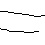

In [6]:
import PIL
import PIL.Image

equal_sign = list(data_dir.glob('=/*'))
PIL.Image.open(str(equal_sign[10]))

In [5]:
batch_size = 32
img_height = 45
img_width = 45

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375974 files belonging to 82 classes.
Using 300780 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375974 files belonging to 82 classes.
Using 75194 files for validation.


In [8]:
train_ds.class_names

['!',
 '(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'C',
 'Delta',
 'G',
 'H',
 'M',
 'N',
 'R',
 'S',
 'T',
 'X',
 '[',
 ']',
 'alpha',
 'ascii_124',
 'b',
 'beta',
 'cos',
 'd',
 'div',
 'e',
 'exists',
 'f',
 'forall',
 'forward_slash',
 'gamma',
 'geq',
 'gt',
 'i',
 'in',
 'infty',
 'int',
 'j',
 'k',
 'l',
 'lambda',
 'ldots',
 'leq',
 'lim',
 'log',
 'lt',
 'mu',
 'neq',
 'o',
 'p',
 'phi',
 'pi',
 'pm',
 'prime',
 'q',
 'rightarrow',
 'sigma',
 'sin',
 'sqrt',
 'sum',
 'tan',
 'theta',
 'times',
 'u',
 'v',
 'w',
 'y',
 'z',
 '{',
 '}']

In [9]:
class_names = tuple(train_ds.class_names)
print(class_names)

('!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}')


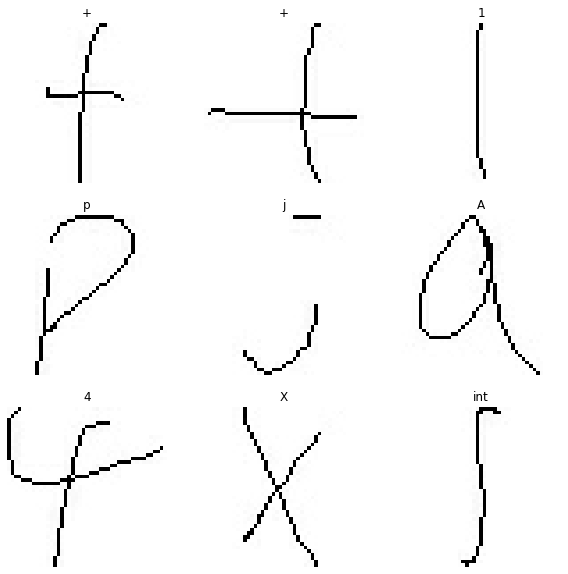

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 45, 45, 3)
(32,)


In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
num_classes = 82

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=5)

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [38]:
%%time


hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks=[es]
).history

Epoch 1/40
9400/9400 [==============================] - 239s 25ms/step - loss: 0.5371 - accuracy: 0.8535 - val_loss: 0.2711 - val_accuracy: 0.9223
Epoch 2/40
9400/9400 [==============================] - 42s 4ms/step - loss: 0.3089 - accuracy: 0.9079 - val_loss: 0.2091 - val_accuracy: 0.9405
Epoch 3/40
9400/9400 [==============================] - 42s 4ms/step - loss: 0.2547 - accuracy: 0.9226 - val_loss: 0.1769 - val_accuracy: 0.9489
Epoch 4/40
9400/9400 [==============================] - 42s 4ms/step - loss: 0.2200 - accuracy: 0.9319 - val_loss: 0.1492 - val_accuracy: 0.9572
Epoch 5/40
9400/9400 [==============================] - 43s 5ms/step - loss: 0.1978 - accuracy: 0.9374 - val_loss: 0.1316 - val_accuracy: 0.9626
Epoch 6/40
9400/9400 [==============================] - 42s 4ms/step - loss: 0.1801 - accuracy: 0.9425 - val_loss: 0.1228 - val_accuracy: 0.9651
Epoch 7/40
9400/9400 [==============================] - 42s 4ms/step - loss: 0.1697 - accuracy: 0.9451 - val_loss: 0.1121 - val_

In [40]:
model.save("/content/drive/MyDrive/modelDL2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/modelDL2/assets


In [38]:
import keras
model = keras.models.load_model("/content/drive/MyDrive/modelDL2")

NameError: ignored

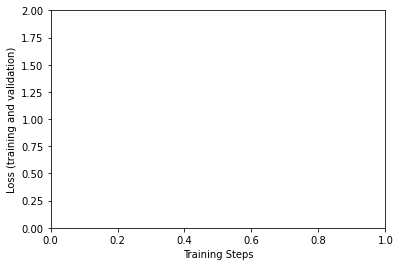

In [34]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
class

In [26]:
from get_test_data import test_data

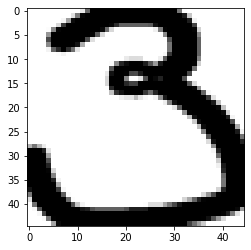

In [42]:
import matplotlib.pyplot as plt
lst=test_data("IMG_5023 copy 2.jpeg")
plt.imshow(lst[2])


In [ ]:
from PIL import Image
im = Image.fromarray(lst[0])
im.save("/content/drive/MyDrive/three.jpeg")

In [43]:
prediction_scores= model.predict(np.expand_dims(lst[2], axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

Predicted label: =


In [60]:
print(len(class_names))

82


In [28]:
for i in range(len(class_names)):
  print(f'{i} {prediction_scores[0][i]} : {class_names[i]}')


0 -11.43178939819336 : !
1 -18.55394744873047 : (
2 -22.035585403442383 : )
3 -8.716032028198242 : +
4 -24.342073440551758 : ,
5 -14.08948802947998 : -
6 -14.945181846618652 : 0
7 -15.262343406677246 : 1
8 -14.331865310668945 : 2
9 -20.248836517333984 : 3
10 -25.290851593017578 : 4
11 -16.91898536682129 : 5
12 -23.58489418029785 : 6
13 -22.341405868530273 : 7
14 -54.33998489379883 : 8
15 -30.47015953063965 : 9
16 -14.468137741088867 : =
17 -20.65869140625 : A
18 -22.003313064575195 : C
19 -31.208581924438477 : Delta
20 -23.397531509399414 : G
21 -31.192262649536133 : H
22 -38.87498474121094 : M
23 -29.469255447387695 : N
24 -37.34000015258789 : R
25 -19.51143455505371 : S
26 -18.420501708984375 : T
27 -26.180463790893555 : X
28 -48.671607971191406 : [
29 -40.387611389160156 : ]
30 -37.78852081298828 : alpha
31 -51.69279479980469 : ascii_124
32 -25.96767234802246 : b
33 -30.651691436767578 : beta
34 -29.181123733520508 : cos
35 -27.818471908569336 : d
36 -16.211671829223633 : div
37 -32

In [36]:
import joblib
joblib.dump(model, 'model.joblib')


INFO:tensorflow:Assets written to: ram://33ec8f03-c89f-4523-bc5e-b69395e6bd54/assets


['model.joblib']

In [ ]:
!pip install opencv-python

  Using cached opencv_python-4.5.5.64-cp36-abi3-macosx_10_15_x86_64.whl (46.3 MB)


In [ ]:
%load_ext autoreload
%autoreload 2
from get_test_data import test_data
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
num=test_data("IMG_5023 copy 2.jpeg")[1]

In [ ]:
num2 = tf.image.rgb_to_grayscale(num)
num2= tf.image.grayscale_to_rgb(num2)
num2.shape

TensorShape([45, 45, 3])

In [ ]:
prediction_scores= model.predict(np.expand_dims(num2, axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

1/1 [==============================] - 0s 27ms/step
Predicted label: +


In [ ]:
# https://www.tensorflow.org/tutorials/load_data/images